# Necessary Imports

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from google.colab import drive, files
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import os
import shutil
from PIL import Image
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

# Data Loading

Loading labeled data from drive.

In [2]:
drive.mount('/content/gdrive')
# Replace with link/path to dataset (In, my case, I uploaded the dataset on my Drive)
zip_file_path = "/content/gdrive/MyDrive/dataset/images_project.zip"
# Unzip the file using the command line
!unzip "$zip_file_path"

Mounted at /content/gdrive
Archive:  /content/gdrive/MyDrive/dataset/images_project.zip
   creating: images_project/
  inflating: images_project/bike_002.bmp  
  inflating: images_project/bike_004.bmp  
  inflating: images_project/bike_005.bmp  
  inflating: images_project/bike_006.bmp  
  inflating: images_project/bike_013.bmp  
  inflating: images_project/bike_014.bmp  
  inflating: images_project/bike_015.bmp  
  inflating: images_project/bike_017.bmp  
  inflating: images_project/bike_020.bmp  
  inflating: images_project/bike_021.bmp  
  inflating: images_project/bike_022.bmp  
  inflating: images_project/bike_024.bmp  
  inflating: images_project/bike_026.bmp  
  inflating: images_project/bike_030.bmp  
  inflating: images_project/bike_031.bmp  
  inflating: images_project/bike_040.bmp  
  inflating: images_project/bike_041.bmp  
  inflating: images_project/bike_042.bmp  
  inflating: images_project/bike_043.bmp  
  inflating: images_project/bike_044.bmp  
  inflating: images_pro

Adding a prefix path to the file name of every image.

In [3]:
destination_folder = "images_project/"
df = pd.read_csv('data.csv')
df['file_name'] = destination_folder + df['file_name']

In [4]:
df

,file_name,caption
0,images_project/horse-16.jpg,a brown horse running in a grassy field .
1,images_project/bike_202.bmp,an orange bicycle parked in front of an iron f...
2,images_project/horse-63.jpg,a black horse standing on top of a grass cover...
3,images_project/carsgraz_367.bmp,a car driving down a street past a billboard .
4,images_project/dog.102.jpg,a close up of a dog wearing a collar .
...,...,...
1798,images_project/dog.146.jpg,a couple of dogs that are on the ground
1799,images_project/bike_276.bmp,a group of bikes parked next to each other .
1800,images_project/dog.147.jpg,a dog standing in a room next to a wall .
1801,images_project/carsgraz_332.bmp,a car parked on the side of the road next to a...


# Model Loading

In [5]:
# Load pre-trained CLIP model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32", padding_token=0)
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,


# Data Processing

Creating our own Custom Dataset.

In [6]:
class ImageDataset(Dataset):
    def __init__(self, list_image_path,list_txt, max_length):
        self.images_paths = list_image_path
        self.captions  = list_txt

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image =self.images_paths[idx]
        text = (self.captions[idx]).lower()
        return  text , image

In [7]:
image_paths = df['file_name'].tolist()
captions = df['caption'].tolist()
dataset = ImageDataset(image_paths, captions, 32)

Dividing the data into a training set and a test set, allocating 80% for training and 20% for testing, and then setting up our data loaders.

In [8]:
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=41)
train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)
train_dataloader = DataLoader(train_subset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_subset, batch_size=16, shuffle=True)

# Model Training

Given that the training loss for the clip model aims to maximize the cosine similarity between similar image and text embeddings while minimizing the cosine similarity between dissimilar ones, we ensure to design a custom loss function that fulfills these criteria.

In [9]:
def contrastive_loss(logits: torch.Tensor) -> torch.Tensor:
    # number of samples
    n = logits.shape[1]
    # Move labels tensor to the same device as logits
    labels = torch.arange(n).to(logits.device)
    # Calculate cross entropy losses along axis 0 and 1
    loss_images = F.cross_entropy(logits.transpose(0, 1), labels, reduction="mean")
    loss_captions = F.cross_entropy(logits, labels, reduction="mean")
    # Calculate the final loss
    total_loss = (loss_images + loss_captions) / 2

    return total_loss

Refining the model using the custom loss function.

In [10]:
optimizer = torch.optim.Adam(clip_model.parameters(), lr=6e-7, betas=(0.9,0.98),eps=1e-9,weight_decay=0.01)
num_epochs = 30
best_val_loss = np.Inf

for epoch in range(num_epochs):
    # TRAINING
    clip_model.train(True)
    total_loss = 0
    pbar_training = tqdm(train_dataloader, total=len(train_dataloader))
    for batch in pbar_training:
        batch_images = []
        # Get batches of data
        text, images = batch
        for path in images:
            with Image.open(path) as img:
                image = img.convert("RGB")
            batch_images.append(image)
        text_inputs = tokenizer(list(text), padding=True, truncation=True, return_tensors="pt")
        # Convert the embeddings to list
        image_pixels = clip_processor(
          text=None,
          images= batch_images,
          return_tensors="pt"
          )["pixel_values"].to(device)
        inputs = {key: value.to(device) for key, value in text_inputs.items()}
        # Forward Pass
        text_features = clip_model.get_text_features(**inputs)
        image_features = clip_model.get_image_features(image_pixels)
        optimizer.zero_grad()
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)
        similarity = text_features @ image_features.T
        loss = contrastive_loss(similarity)
        # Backward pass
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        training_loss = loss.item()
        pbar_training.set_description(f"Epoch {epoch + 1}/{num_epochs} Training Loss: {training_loss:.4f}", refresh=True)

    # EVALUATION
    clip_model.eval()
    total_loss_val = 0
    pbar_validation = tqdm(test_dataloader, total=len(test_dataloader))
    with torch.no_grad():
      for batch in pbar_validation:
          batch_images = []
          # Get batches of data
          text, images = batch
          for path in images:
              with Image.open(path) as img:
                  image = img.convert("RGB")
              batch_images.append(image)
          text_inputs = tokenizer(list(text), padding=True, truncation=True, return_tensors="pt")
          # Convert the embeddings to list
          image_pixels = clip_processor(
            text=None,
            images= batch_images,
            return_tensors="pt"
            )["pixel_values"].to(device)
          inputs = {key: value.to(device) for key, value in text_inputs.items()}
          # Generate embeddings
          text_features = clip_model.get_text_features(**inputs)
          image_features = clip_model.get_image_features(image_pixels)
          optimizer.zero_grad()
          image_features = image_features / image_features.norm(dim=1, keepdim=True)
          text_features = text_features / text_features.norm(dim=1, keepdim=True)
          similarity = text_features @ image_features.T
          loss = contrastive_loss(similarity)
          total_loss_val += loss.item()
          validation_loss = loss.item()
          pbar_validation.set_description(f"Epoch {epoch + 1}/{num_epochs} Validation Loss: {validation_loss:.4f}", refresh=True)

    if (total_loss_val/len(test_dataloader) < best_val_loss):
        # Saving best model
        print("BEST VALIDATION LOSS")
        torch.save(clip_model.state_dict(), 'optimized_model.pt')
        best_val_loss = total_loss_val/len(test_dataloader)

    print(f"Epoch {epoch + 1}/{num_epochs} Training Loss: {total_loss/len(train_dataloader):.4f}  Validation Loss: {total_loss_val/len(test_dataloader):.4f}")
    print("=======================================================================================")

Epoch 1/30 Validation Loss: 1.8964: 100%|██████████| 23/23 [00:05<00:00,  3.93it/s]


BEST VALIDATION LOSS
Epoch 1/30 Training Loss: 2.5455  Validation Loss: 2.4664


Epoch 2/30 Validation Loss: 1.7587: 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]


BEST VALIDATION LOSS
Epoch 2/30 Training Loss: 2.3922  Validation Loss: 2.3263


Epoch 3/30 Validation Loss: 1.7618: 100%|██████████| 23/23 [00:06<00:00,  3.57it/s]


BEST VALIDATION LOSS
Epoch 3/30 Training Loss: 2.2713  Validation Loss: 2.2187


Epoch 4/30 Validation Loss: 1.6036: 100%|██████████| 23/23 [00:05<00:00,  3.93it/s]


BEST VALIDATION LOSS
Epoch 4/30 Training Loss: 2.1754  Validation Loss: 2.1607


Epoch 5/30 Validation Loss: 1.5722: 100%|██████████| 23/23 [00:05<00:00,  4.11it/s]


BEST VALIDATION LOSS
Epoch 5/30 Training Loss: 2.1270  Validation Loss: 2.1096


Epoch 6/30 Validation Loss: 1.5096: 100%|██████████| 23/23 [00:05<00:00,  4.12it/s]


BEST VALIDATION LOSS
Epoch 6/30 Training Loss: 2.0878  Validation Loss: 2.0822


Epoch 7/30 Validation Loss: 1.5659: 100%|██████████| 23/23 [00:06<00:00,  3.74it/s]


BEST VALIDATION LOSS
Epoch 7/30 Training Loss: 2.0557  Validation Loss: 2.0545


Epoch 8/30 Validation Loss: 1.5676: 100%|██████████| 23/23 [00:05<00:00,  4.26it/s]


BEST VALIDATION LOSS
Epoch 8/30 Training Loss: 2.0322  Validation Loss: 2.0308


Epoch 9/30 Validation Loss: 1.5479: 100%|██████████| 23/23 [00:05<00:00,  3.83it/s]


BEST VALIDATION LOSS
Epoch 9/30 Training Loss: 2.0200  Validation Loss: 2.0070


Epoch 10/30 Validation Loss: 1.5636: 100%|██████████| 23/23 [00:06<00:00,  3.53it/s]


Epoch 10/30 Training Loss: 2.0072  Validation Loss: 2.0278


Epoch 11/30 Validation Loss: 1.5283: 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]


Epoch 11/30 Training Loss: 1.9943  Validation Loss: 2.0076


Epoch 12/30 Validation Loss: 1.4705: 100%|██████████| 23/23 [00:05<00:00,  4.13it/s]


BEST VALIDATION LOSS
Epoch 12/30 Training Loss: 1.9943  Validation Loss: 1.9934


Epoch 13/30 Validation Loss: 1.4143: 100%|██████████| 23/23 [00:06<00:00,  3.54it/s]


BEST VALIDATION LOSS
Epoch 13/30 Training Loss: 1.9812  Validation Loss: 1.9856


Epoch 14/30 Validation Loss: 1.5074: 100%|██████████| 23/23 [00:06<00:00,  3.73it/s]


Epoch 14/30 Training Loss: 1.9747  Validation Loss: 1.9994


Epoch 15/30 Validation Loss: 1.4492: 100%|██████████| 23/23 [00:05<00:00,  4.20it/s]


Epoch 15/30 Training Loss: 1.9808  Validation Loss: 1.9966


Epoch 16/30 Validation Loss: 1.4424: 100%|██████████| 23/23 [00:05<00:00,  4.21it/s]


BEST VALIDATION LOSS
Epoch 16/30 Training Loss: 1.9733  Validation Loss: 1.9738


Epoch 17/30 Validation Loss: 1.5062: 100%|██████████| 23/23 [00:06<00:00,  3.48it/s]


Epoch 17/30 Training Loss: 1.9619  Validation Loss: 2.0072


Epoch 18/30 Validation Loss: 1.5975: 100%|██████████| 23/23 [00:06<00:00,  3.80it/s]


Epoch 18/30 Training Loss: 1.9649  Validation Loss: 1.9888


Epoch 19/30 Validation Loss: 1.4319: 100%|██████████| 23/23 [00:05<00:00,  4.16it/s]


Epoch 19/30 Training Loss: 1.9659  Validation Loss: 1.9995


Epoch 20/30 Validation Loss: 1.5356: 100%|██████████| 23/23 [00:05<00:00,  4.06it/s]


BEST VALIDATION LOSS
Epoch 20/30 Training Loss: 1.9581  Validation Loss: 1.9638


Epoch 21/30 Validation Loss: 1.5411: 100%|██████████| 23/23 [00:06<00:00,  3.42it/s]


Epoch 21/30 Training Loss: 1.9641  Validation Loss: 1.9875


Epoch 22/30 Validation Loss: 1.4781: 100%|██████████| 23/23 [00:05<00:00,  4.16it/s]


Epoch 22/30 Training Loss: 1.9589  Validation Loss: 1.9717


Epoch 23/30 Validation Loss: 1.4290: 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]


BEST VALIDATION LOSS
Epoch 23/30 Training Loss: 1.9545  Validation Loss: 1.9603


Epoch 24/30 Validation Loss: 1.4517: 100%|██████████| 23/23 [00:06<00:00,  3.55it/s]


Epoch 24/30 Training Loss: 1.9513  Validation Loss: 1.9740


Epoch 25/30 Validation Loss: 1.4125: 100%|██████████| 23/23 [00:06<00:00,  3.58it/s]


Epoch 25/30 Training Loss: 1.9522  Validation Loss: 1.9735


Epoch 26/30 Validation Loss: 1.4362: 100%|██████████| 23/23 [00:05<00:00,  4.22it/s]


Epoch 26/30 Training Loss: 1.9597  Validation Loss: 1.9797


Epoch 27/30 Validation Loss: 1.4830: 100%|██████████| 23/23 [00:05<00:00,  4.24it/s]


Epoch 27/30 Training Loss: 1.9477  Validation Loss: 1.9821


Epoch 28/30 Validation Loss: 1.3699: 100%|██████████| 23/23 [00:06<00:00,  3.70it/s]


BEST VALIDATION LOSS
Epoch 28/30 Training Loss: 1.9439  Validation Loss: 1.9580


Epoch 29/30 Validation Loss: 1.3638: 100%|██████████| 23/23 [00:06<00:00,  3.74it/s]


Epoch 29/30 Training Loss: 1.9499  Validation Loss: 1.9744


Epoch 30/30 Validation Loss: 1.5042: 100%|██████████| 23/23 [00:05<00:00,  4.22it/s]

Epoch 30/30 Training Loss: 1.9624  Validation Loss: 1.9704


# Saving Model Parameters

In [ ]:
files.download('/content/optimized_model.pt')

In [38]:
source_file_path = '/content/optimized_model.pt'

# Destination path in Google Drive
destination_folder = '/content/gdrive/My Drive/'
destination_file_path = destination_folder + 'optimized_model.pt'

# Copy the file to Google Drive
shutil.copyfile(source_file_path, destination_file_path)

'/content/gdrive/My Drive/optimized_model.pt'

# Checking Performance

Loading the best model that was saved.

In [11]:
clip_model.load_state_dict(torch.load('optimized_model.pt'))
clip_model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

Generating all images embeddings.

In [12]:
image_embeddings = []
# Convert the embeddings to list

for i, row in df.iterrows():
  with torch.no_grad():
    image = clip_processor(
          text=None,
          images=Image.open(row['file_name']).convert("RGB"),
          return_tensors="pt"
          )["pixel_values"].to(device)
    image_features = clip_model.get_image_features(image)
    image_embeddings.append(image_features)

Get indices of the top five images that are similar to a query vector.

In [13]:
def find_top_similar_vector_indexes(query_vector, vector_list, top_n=5):
    # Move query_vector to CPU if it's on GPU
    query_vector = query_vector.cpu() if query_vector.is_cuda else query_vector
    # Move all tensors in vector_list to CPU if they're on GPU
    vector_list = [vector.cpu() if vector.is_cuda else vector for vector in vector_list]

    # Flatten the tensors in vector_list to 2 dimensions
    flattened_vectors = [vector.numpy().flatten() for vector in vector_list]

    # Compute cosine similarity between the query vector and all flattened vectors in the list
    similarities = cosine_similarity([query_vector.detach().numpy().flatten()], flattened_vectors)
    # Flatten the similarities array
    similarities = similarities.flatten()
    # Sort indices based on similarity scores in descending order
    top_indices = np.argsort(similarities)[::-1][:top_n]
    # Return the indices
    return top_indices

Showing images that are similar based on a list of indices.

In [14]:
def display_images_from_dataframe_indices(df, indices, figsize=(15, 20)):
    df_filtered = df.loc[indices]
    fig, axes = plt.subplots(ncols=len(df_filtered), nrows=1, figsize=figsize)
    fig.tight_layout(pad=3.0)

    for ax, idx in zip(axes, df_filtered.index):
        image_path = df_filtered.loc[idx, 'file_name']
        if os.path.exists(image_path):
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(f"Index: {idx}")
        else:
            ax.axis('off')
            ax.set_title(f"Index: {idx} (Image not found)")

    plt.show()

Testing with a text query.

In [31]:
query = "a woman with blond hair"
with torch.no_grad():
  inputs = tokenizer(query, return_tensors="pt")
  inputs = {key: value.to(device) for key, value in inputs.items()}
  # Generate embeddings
  text = clip_model.get_text_features(**inputs)

In [32]:
indexes = find_top_similar_vector_indexes(text[0], image_embeddings)

In [33]:
top_images = indexes[0]

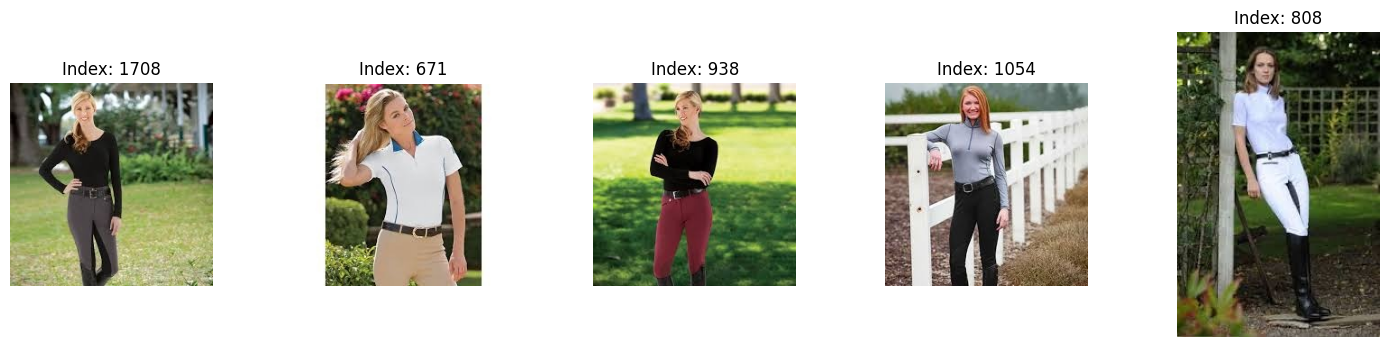

In [34]:
display_images_from_dataframe_indices(df, indexes)